# Zee Recommender Systems: Personalized Movie Recommendations

In [365]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

## Dataset Loading

In [2]:
# The respective datasets
movies_df = pd.read_csv("ZEE-data/zee-movies.dat", sep="::", engine='python', encoding='ISO-8859-1')
ratings_df = pd.read_csv("ZEE-data/zee-ratings.dat", sep="::", engine='python', encoding='ISO-8859-1')
users_df = pd.read_csv("ZEE-data/zee-users.dat", sep="::", engine='python', encoding='ISO-8859-1')

In [5]:
print(f"Shape of movies df = {movies_df.shape},\nShape of Ratings df = {ratings_df.shape},\nShape of Users df =  {users_df.shape}")

Shape of movies df = (3883, 3),
Shape of Ratings df = (1000209, 4),
Shape of Users df =  (6040, 5)


### Movies DF Exploration

In [6]:
movies_df.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Obtaining Release_Year feature
movies_df['Release_year'] = movies_df.Title.str.split('(').str[-1].str.split(")").str[0]

In [8]:
# Function for removing the Year from Title
def remove_year(title):
    return re.sub(r'\s*\(\d+\)$',"", title)

In [9]:
# Removing the year from the Movie title
movies_df.Title = movies_df['Title'].apply(remove_year)

In [10]:
# Splitting the movies based on Genre
movies_df.Genres = movies_df.Genres.str.split('|')

# Exploding the dataframe on the basis of Genres
movies_df = movies_df.explode('Genres').reset_index(drop=True)

In [12]:
movies_df

,Movie ID,Title,Genres,Release_year
0,1,Toy Story,Animation,1995
1,1,Toy Story,Children's,1995
2,1,Toy Story,Comedy,1995
3,2,Jumanji,Adventure,1995
4,2,Jumanji,Children's,1995
...,...,...,...,...
6403,3949,Requiem for a Dream,Drama,2000
6404,3950,Tigerland,Drama,2000
6405,3951,Two Family House,Drama,2000
6406,3952,"Contender, The",Drama,2000


In [48]:
# Convert the Release_year datatype to int
movies_df.Release_year = movies_df.Release_year.astype('int')

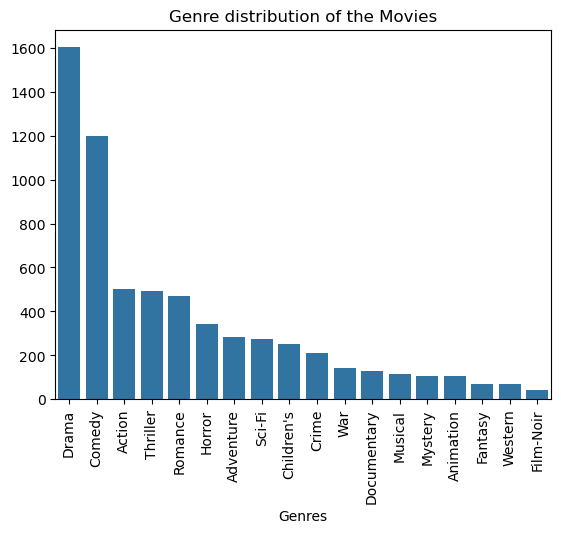

In [193]:
# Plot the Genre distribution of the Movies
genre_counts = movies_df['Genres'].value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title("Genre distribution of the Movies")
plt.xticks(rotation=90)
plt.show()

    - Maximum movies belong to the Drame genre followed by Comedy, Action, Thriller, Romance, Horror, Adventure

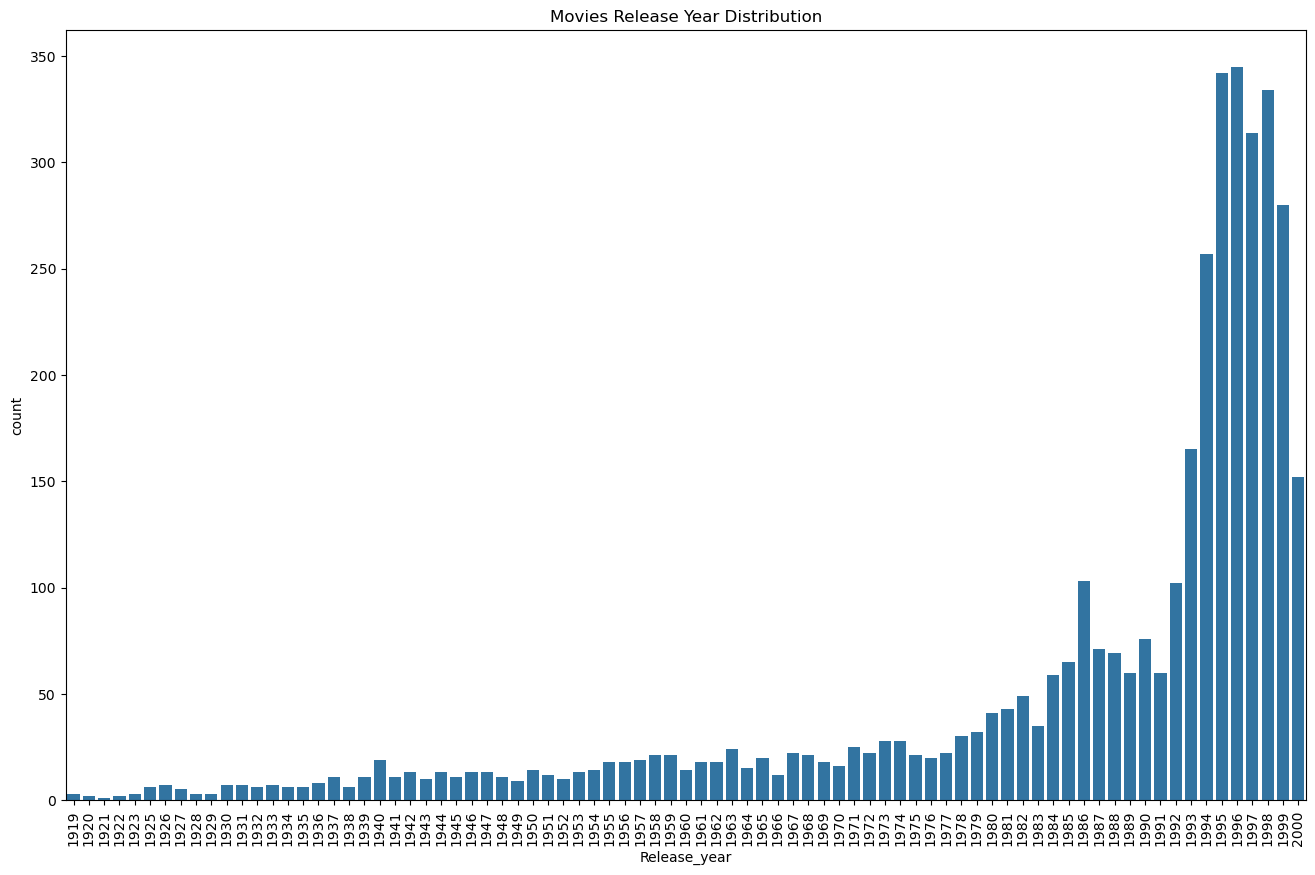

In [71]:
# Plot the Release Year distribution of the Movies
plt.figure(figsize=(16,10))
sns.countplot(movies_df.groupby('Title').agg({'Release_year':'first'}), x='Release_year')
plt.title("Movies Release Year Distribution")
plt.xticks(rotation=90)
plt.show()

In [84]:
# Since, we exploded the movies dataframe on the Genre, hence there could be multiple entries of movies
# To obtain the single entry corresponding to the movie for getting the actual number of movie releases
# We applied groupby on the movies and took the first entry of the Year
movies_df.groupby('Title').agg({'Release_year':'first'}).value_counts()

Release_year
1996            345
1995            342
1998            334
1997            314
1999            280
               ... 
1923              3
1919              3
1920              2
1922              2
1921              1
Name: count, Length: 81, dtype: int64

    - Maximum number of movies were release in year 1996 followed by 1995, 1998, 1997, 1999, 1994, 1993, 2000, 1992

In [184]:
# Function for mapping the year to corresponding decade
def map_to_decade(year):
    if year > 1918 and year <= 1930:
        return '20s'
    elif year > 1930 and year <= 1940:
        return '30s'
    elif year > 1940 and year <= 1950:
        return '40s'
    elif year > 1950 and year <= 1960:
        return '50s'
    elif year > 1960 and year <= 1970:
        return '60s'
    elif year > 1970 and year <= 1980:
        return '70s'
    elif year > 1980 and year <= 1990:
        return '80s'
    elif year > 1990 and year <= 2000:
        return '90s'
    elif year > 2000 and year <= 2010:
        return '2000s'
    elif year > 2010 and year <= 2020:
        return '2010s'
    else:
        return 'Unknown'

In [185]:
movies_df['Decade'] = movies_df['Release_year'].apply(map_to_decade)

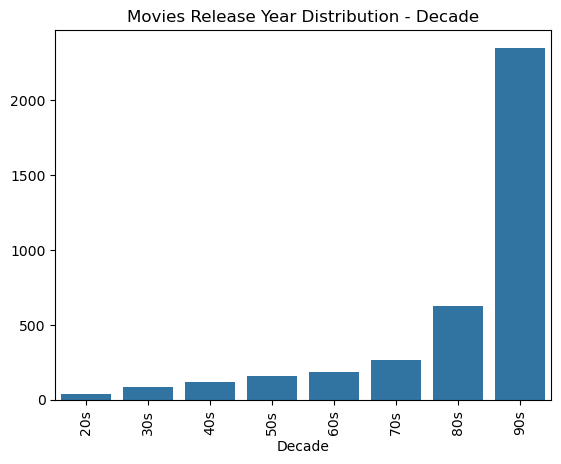

In [191]:
# Plot the Release Year (decade) distribution of the Movies
# plt.figure(figsize=(16,10))
decade_counts = movies_df.groupby('Title').agg({'Decade':'first'})['Decade'].value_counts().sort_index()
sns.barplot(x=decade_counts.index, y=decade_counts.values)
plt.title("Movies Release Year Distribution - Decade")
plt.xticks(rotation=90)
plt.show()

### Ratings DF Exploration

In [13]:
# View the top items of ratings dataframe
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [14]:
# Converting the Timestamp into legible format
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')

In [15]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


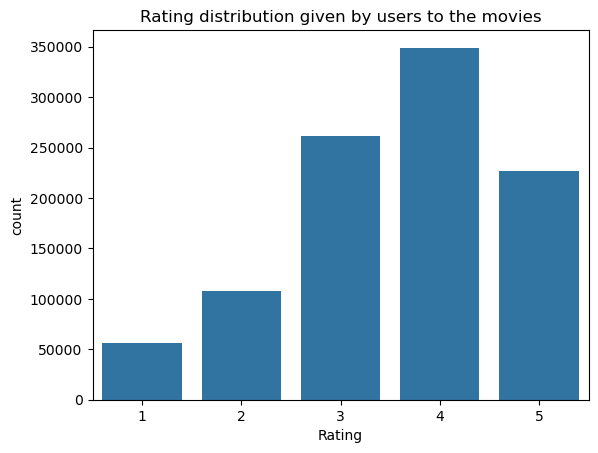

In [87]:
# Plot the Ratings distribution
sns.countplot(ratings_df, x='Rating')
plt.title("Rating distribution given by users to the movies")
plt.show()

    - Max Rating is 4 star, followed by 3, 5, 2, and 1

In [103]:
ratings_df.groupby('UserID').agg({'MovieID':'count'}).reset_index().sort_values(by='MovieID', ascending=False).reset_index(drop=True)

,UserID,MovieID
0,4169,2314
1,1680,1850
2,4277,1743
3,1941,1595
4,1181,1521
...,...,...
6035,5725,20
6036,3407,20
6037,1664,20
6038,4419,20


In [113]:
df = ratings_df.groupby('UserID').agg({'MovieID':'count'}).reset_index().sort_values(by='MovieID', ascending=False).reset_index(drop=True).loc[0:20]

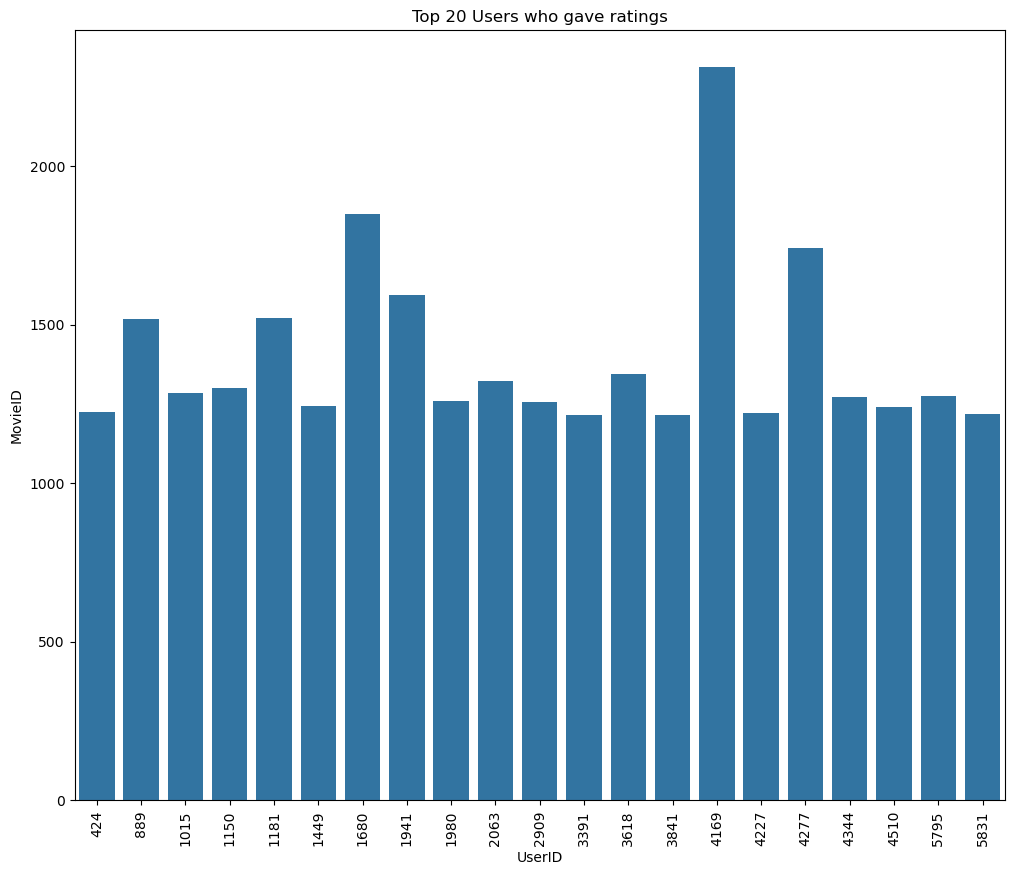

In [114]:
plt.figure(figsize=(12,10))
sns.barplot(data=df, x='UserID', y='MovieID')
plt.xticks(rotation=90)
plt.title("Top 20 Users who gave ratings")
plt.show()

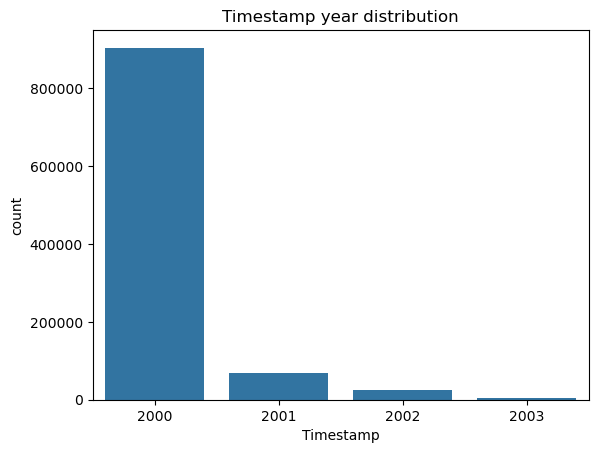

In [132]:
# Plot the Ratings Timestamp year Distribution
sns.barplot(ratings_df.Timestamp.dt.year.value_counts().reset_index(), x='Timestamp', y='count')
plt.title("Timestamp year distribution")
plt.show()

    - Maximum ratings were made during 2000

In [136]:
df = ratings_df.Timestamp.dt.time.value_counts().reset_index()

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81910 entries, 0 to 81909
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  81910 non-null  object
 1   count      81910 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


### Users DF Exploration

In [16]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


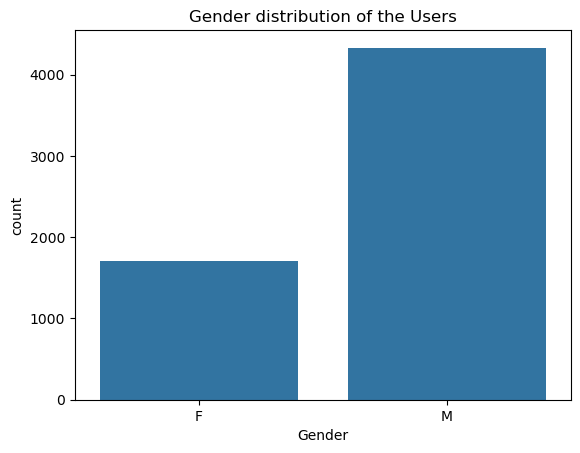

In [28]:
# Plot the Gender distribution of the users
sns.countplot(users_df, x='Gender')
plt.title("Gender distribution of the Users")
plt.show()

    - Maximum number of users are Male

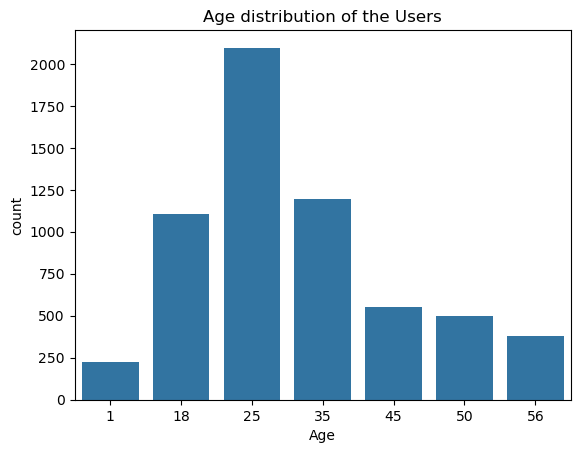

In [25]:
# Plot the Age distribution of the users
sns.countplot(users_df, x='Age')
plt.title("Age distribution of the Users")
plt.show()

    - Highest number of users belong to the age group of 25-34 years
    - Second Highest number of users belong to age bracket 35-44 years
    - Followed by 18-24 years
    - Least participation was from Under 18 age group

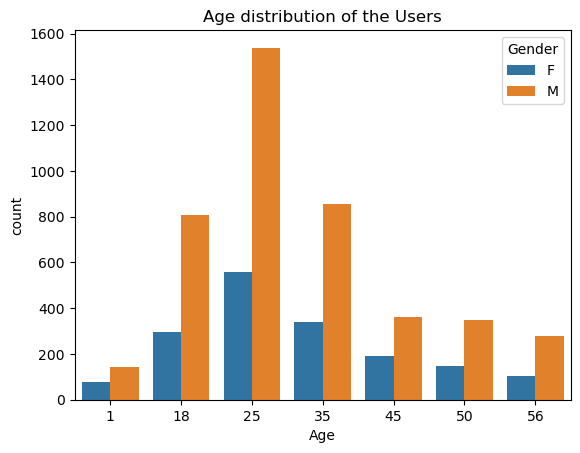

In [29]:
# Plot the Age distribution of the users along with Gender proportion
sns.countplot(users_df, x='Age', hue='Gender')
plt.title("Age distribution of the Users")
plt.show()

In [202]:
# Replace numerical codes with categorical values for Occupation
occupation_mapping = {
0: 'Other or not specified',
1: 'Academic/Educator',
2: 'Artist',
3: 'Clerical/Admin',
4: 'College/Grad Student',
5: 'Customer Service',
6: 'Doctor/Health Care',
7: 'Executive/Managerial',
8: 'Farmer',
9: 'Homemaker',
10: 'K-12 Student',
11: 'Lawyer',
12: 'Programmer',
13: 'Retired',
14: 'Sales/Marketing',
15: 'Scientist',
16: 'Self-Employed',
17: 'Technician/Engineer',
18: 'Tradesman/Craftsman',
19: 'Unemployed',
20: 'Writer'
}
users_df['Occupation'] = users_df['Occupation'].replace(occupation_mapping)

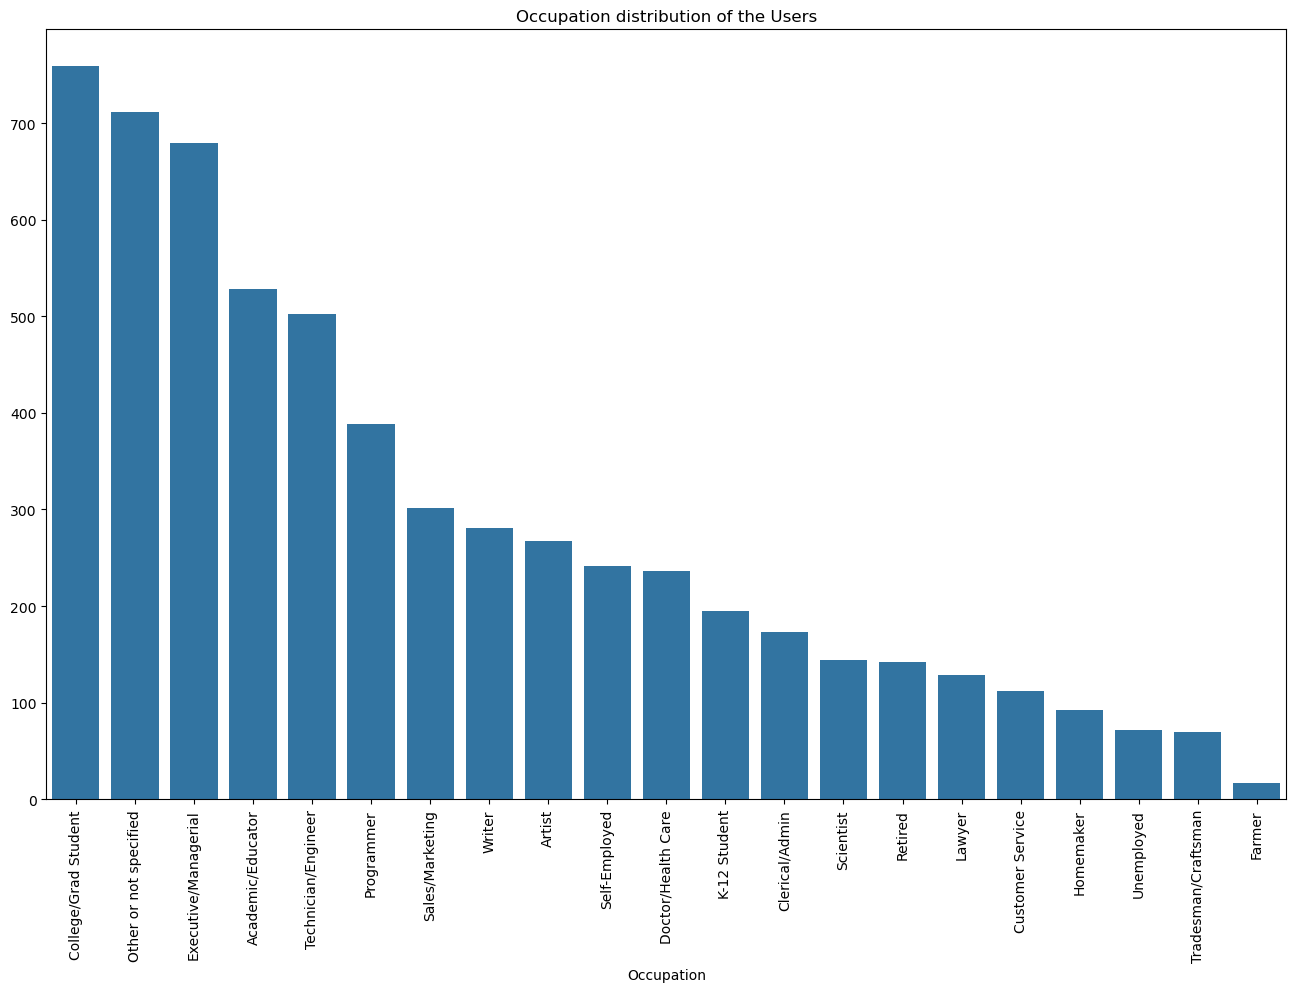

In [209]:
# Plot the Occupation distribution of the users
occupation_counts = users_df['Occupation'].value_counts()
plt.figure(figsize=(16,10))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values)
plt.xticks(rotation=90)
plt.title("Occupation distribution of the Users")
plt.show()

    - College/Grad students had the highest participation
    - Others had the 2nd highest position
    - Exceutive/Managerial users had the 3rd highest participation
    - Followed by Academic/Educator
    - Least participation was from Farmers

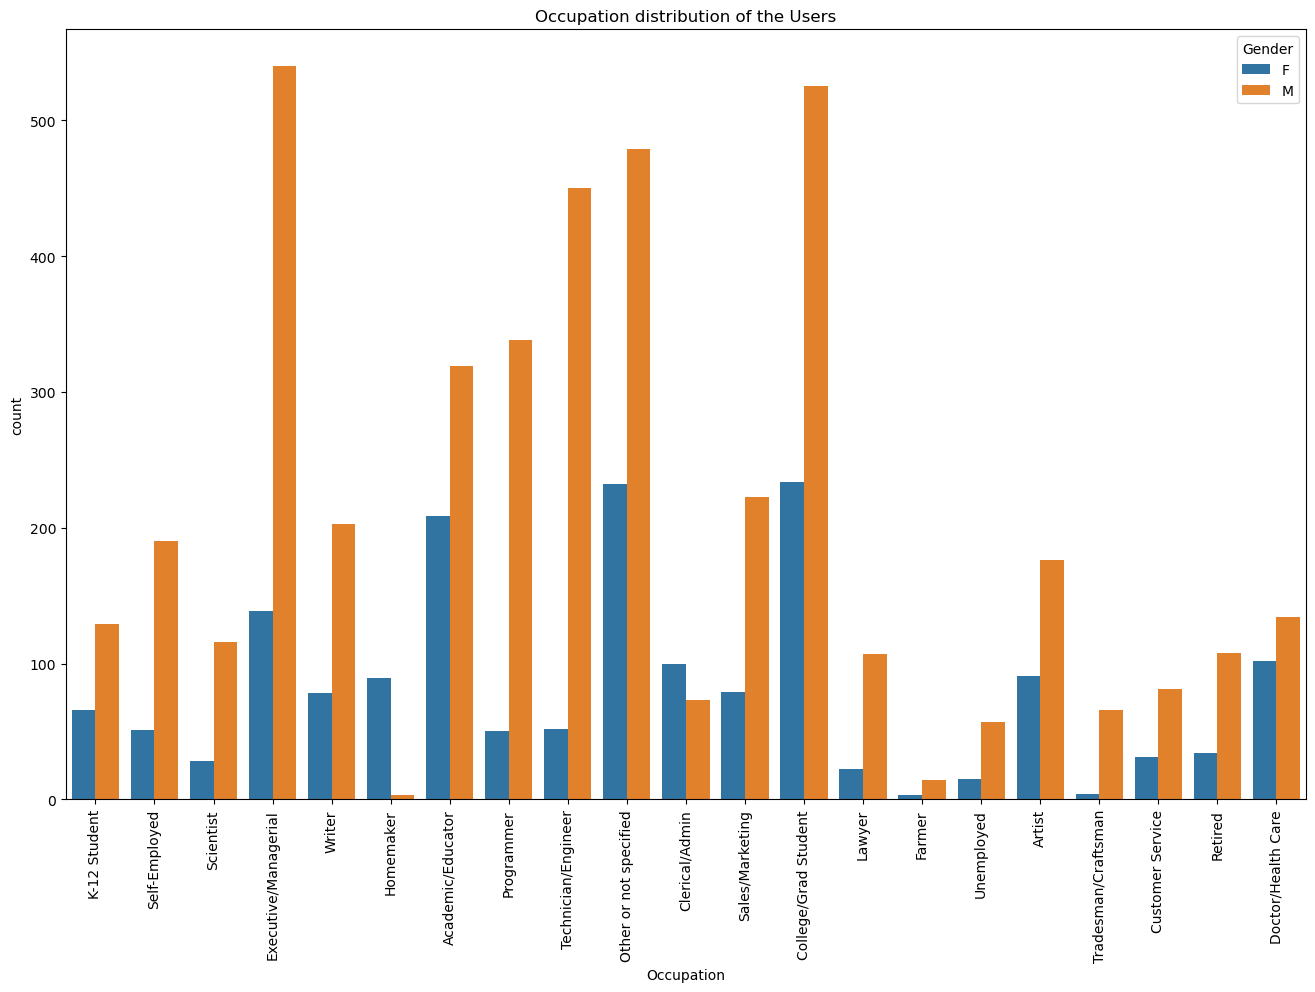

In [213]:
# Plot the Occupation distribution of the users along with gender
plt.figure(figsize=(16,10))
sns.countplot(users_df, x='Occupation', hue='Gender')
plt.xticks(rotation=90)
plt.title("Occupation distribution of the Users")
plt.show()

    - Women users out numbered Men in Clerical/Admin and Homemaker occupation 

In [143]:
movies_df.isnull().sum()

Movie ID        0
Title           0
Genres          0
Release_year    0
dtype: int64

In [144]:
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [145]:
users_df.isnull().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [214]:
# Renaming the 'Movie ID' column to 'MovieID' in movies_df
movies_df.rename(columns={'Movie ID':"MovieID"}, inplace=True)

In [215]:
movies_df.head()

,MovieID,Title,Genres,Release_year,Decade
0,1,Toy Story,Animation,1995,90s
1,1,Toy Story,Children's,1995,90s
2,1,Toy Story,Comedy,1995,90s
3,2,Jumanji,Adventure,1995,90s
4,2,Jumanji,Children's,1995,90s


## Combining the datafiles into single Dataframe

In [216]:
# Merging the ratings_df and movies_df on MovieID
merged_df = pd.merge(movies_df, ratings_df, on='MovieID', how='inner')

# Display the merged dataframe
merged_df.head()

,MovieID,Title,Genres,Release_year,Decade,UserID,Rating,Timestamp
0,1,Toy Story,Animation,1995,90s,1,5,2001-01-06 23:37:48
1,1,Toy Story,Animation,1995,90s,6,4,2000-12-31 04:30:08
2,1,Toy Story,Animation,1995,90s,8,4,2000-12-31 03:31:36
3,1,Toy Story,Animation,1995,90s,9,5,2000-12-31 01:25:52
4,1,Toy Story,Animation,1995,90s,10,5,2000-12-31 01:34:34


In [273]:
# Merging the merged_df and Users dataframe on columns 'UserID'
df = pd.merge(merged_df, users_df, on='UserID', how='inner')
# Display the final merged dataframe
df.head()

,MovieID,Title,Genres,Release_year,Decade,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,Animation,1995,90s,1,5,2001-01-06 23:37:48,F,1,K-12 Student,48067
1,1,Toy Story,Children's,1995,90s,1,5,2001-01-06 23:37:48,F,1,K-12 Student,48067
2,1,Toy Story,Comedy,1995,90s,1,5,2001-01-06 23:37:48,F,1,K-12 Student,48067
3,48,Pocahontas,Animation,1995,90s,1,5,2001-01-06 23:39:11,F,1,K-12 Student,48067
4,48,Pocahontas,Children's,1995,90s,1,5,2001-01-06 23:39:11,F,1,K-12 Student,48067


In [274]:
df.shape

(2101815, 12)

### Performing some exploration in the Complete Merged Dataframe

In [232]:
df.head()

,MovieID,Title,Genres,Release_year,Decade,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,Animation,1995,90s,1,5,2001-01-06 23:37:48,F,1,K-12 Student,48067
1,48,Pocahontas,Animation,1995,90s,1,5,2001-01-06 23:39:11,F,1,K-12 Student,48067
2,150,Apollo 13,Drama,1995,90s,1,5,2000-12-31 22:29:37,F,1,K-12 Student,48067
3,260,Star Wars: Episode IV - A New Hope,Action,1977,70s,1,4,2000-12-31 22:12:40,F,1,K-12 Student,48067
4,527,Schindler's List,Drama,1993,90s,1,5,2001-01-06 23:36:35,F,1,K-12 Student,48067


In [239]:
df.Age.value_counts()

Age
25    831332
35    417534
18    391839
45    173677
50    149791
56     78822
1      58820
Name: count, dtype: int64

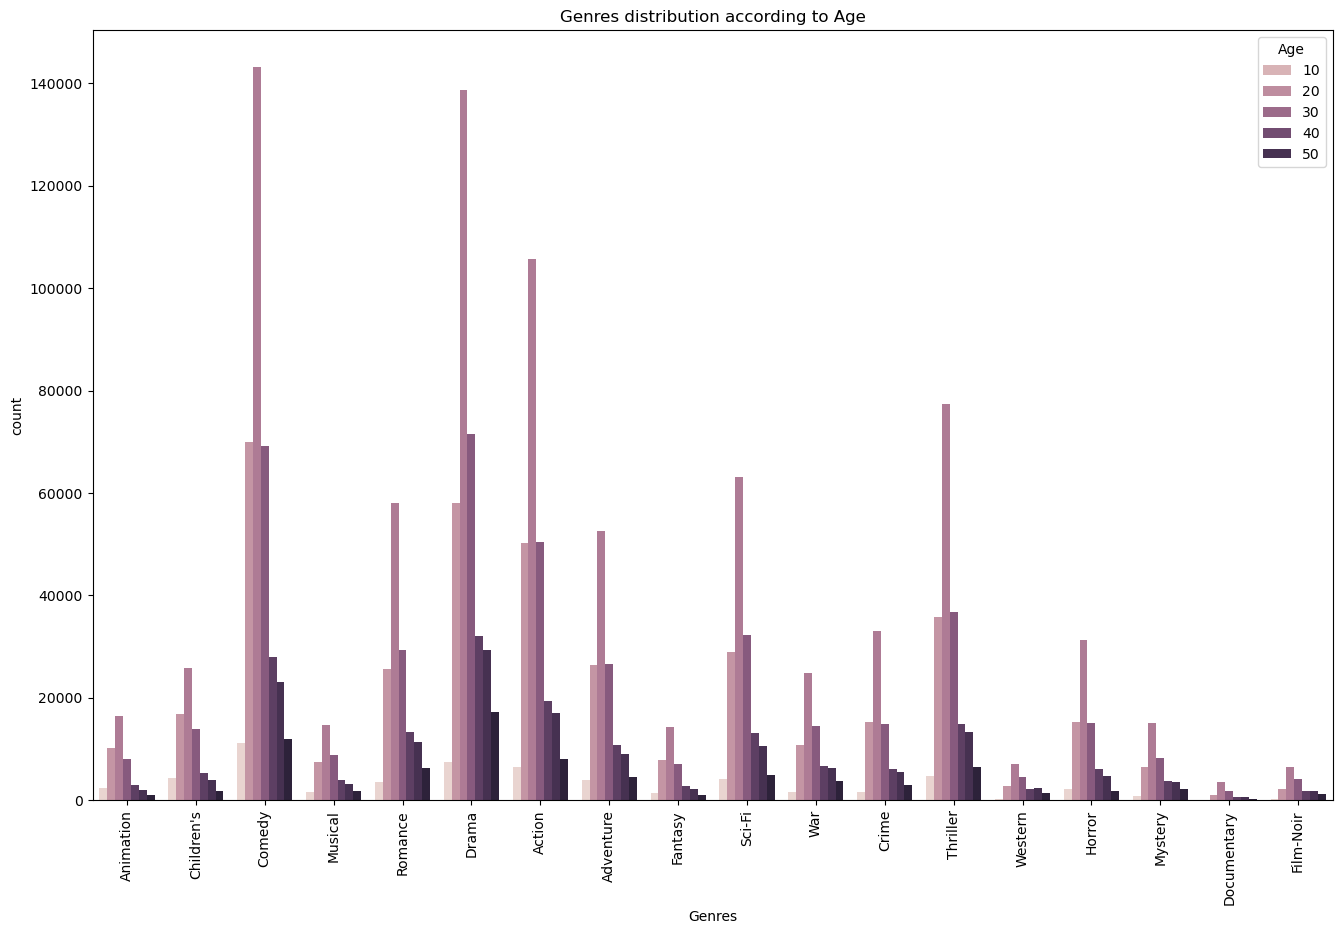

In [240]:
# Plot the age and genre relationship
plt.figure(figsize=(16,10))
sns.countplot(df, x='Genres', hue='Age')
plt.xticks(rotation=90)
plt.title("Genres distribution according to Age")
plt.show()

    - Maximum People watch Comedy and of which 25-34 years demographic contribution is more
    - Least people watch Documentary

In [257]:
df.groupby(['Genres']).agg({'Rating':'mean'}).reset_index().sort_values('Rating')

,Genres,Rating
10,Horror,3.215013
3,Children's,3.422035
8,Fantasy,3.447371
14,Sci-Fi,3.466521
1,Adventure,3.477257
0,Action,3.491185
4,Comedy,3.522099
15,Thriller,3.570466
13,Romance,3.607465
17,Western,3.637770


In [245]:
avg_genre_age_rating = df.groupby(['Genres','Age']).agg({'Rating':'mean'}).reset_index()

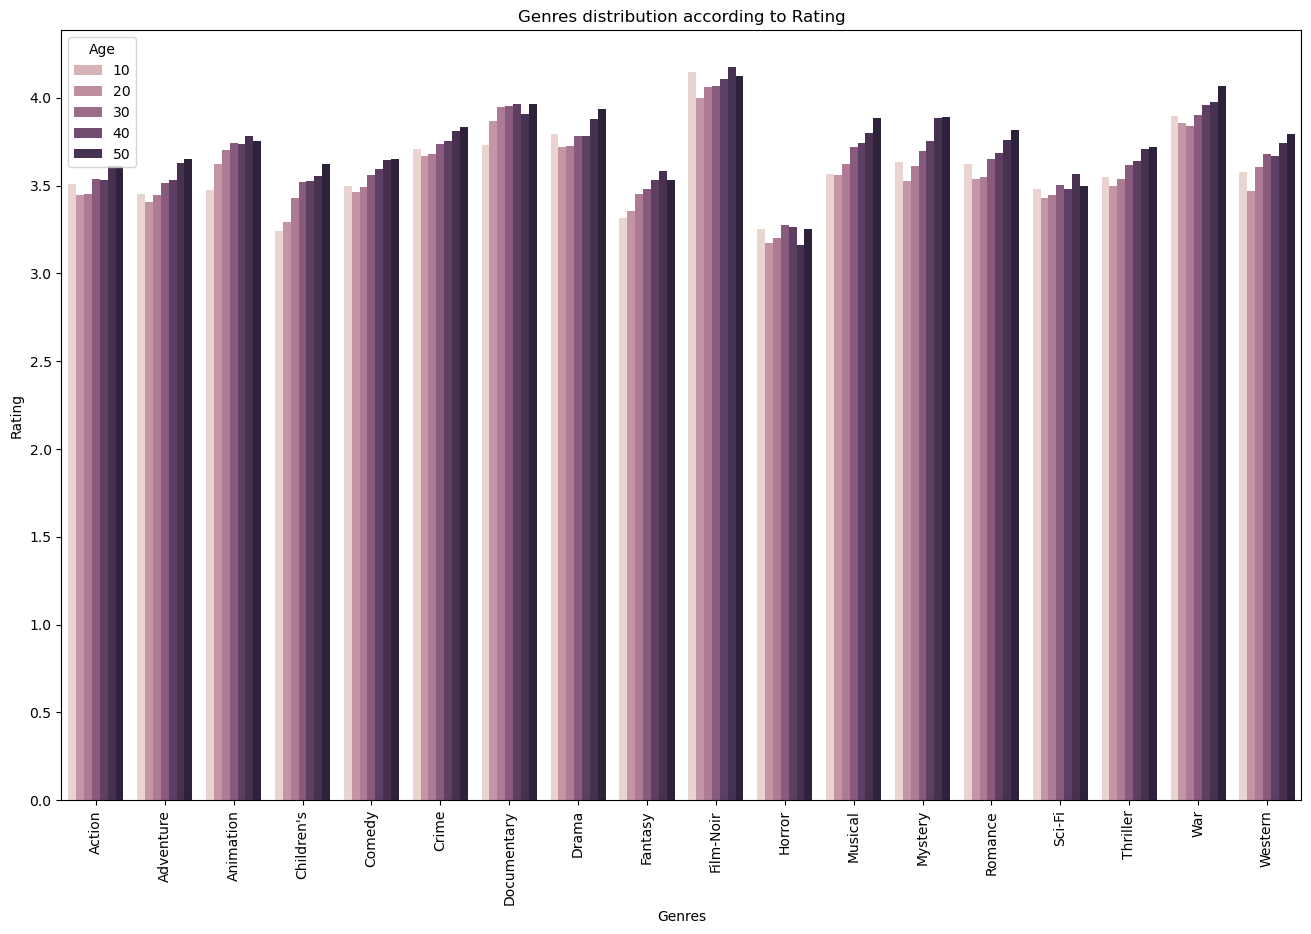

In [253]:
# Plot the age and genre relationship
plt.figure(figsize=(16,10))
sns.barplot(avg_genre_age_rating, x='Genres', y='Rating', hue='Age')
plt.xticks(rotation=90)
plt.title("Genres distribution according to Rating")
plt.show()

    - Film-Noir is the highest rated Genre, followed by Documentary, War, Drama
    - Horror, Children's genre is the least rated
    - Action, Adventure, COmedy, Crime, Drama, Film-noir, Horror, Mystery, Sci-fi, Thriller, War and Western are popular among under 18 
    than their counterpart 19-34 age group people
    - War, Western, Romance, Musical, Drama and Documentary are most popular among the 56+ Age group

In [258]:
avg_genre_gender_rating = df.groupby(['Genres','Gender']).agg({'Rating':'mean'}).reset_index()

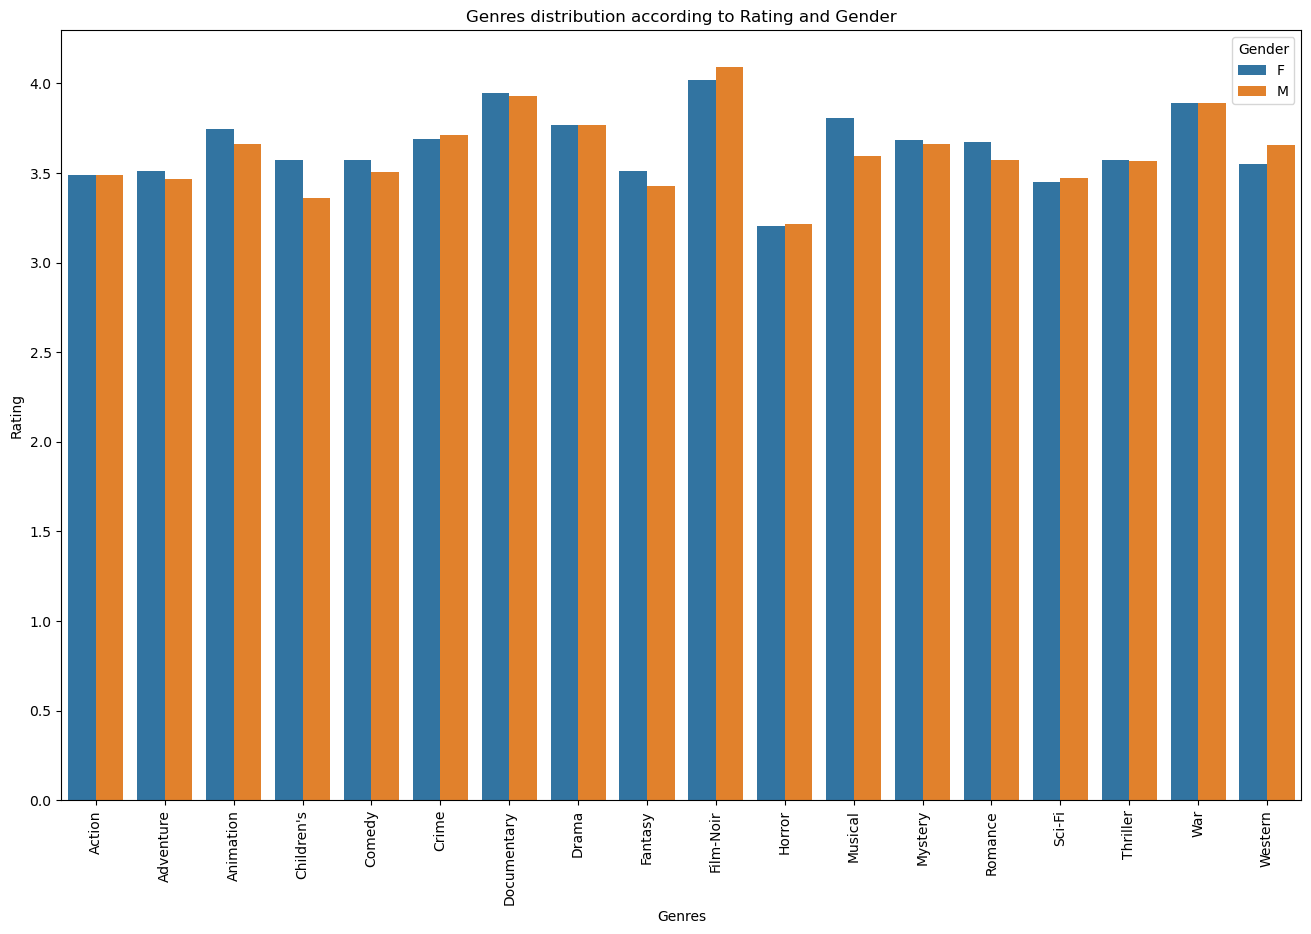

In [260]:
# Plot the gender and genre relationship
plt.figure(figsize=(16,10))
sns.barplot(avg_genre_gender_rating, x='Genres', y='Rating', hue='Gender')
plt.xticks(rotation=90)
plt.title("Genres distribution according to Rating and Gender")
plt.show()

    - Western, Sci-Fi, Film-Noir, Horror, Crime are more popular in Males as compared to Females
    - Adventure, Animation, Childern's, Comedy, Documentary, Musical, Mystery, Romance genres are more popular with Females

In [263]:
avg_genre_decade = df.groupby(['Genres','Decade']).agg({'MovieID':'count'}).reset_index()

In [264]:
avg_genre_decade

,Genres,Decade,MovieID
0,Action,20s,66
1,Action,30s,1151
2,Action,40s,202
3,Action,50s,3985
4,Action,60s,9882
...,...,...,...
130,Western,50s,1147
131,Western,60s,5669
132,Western,70s,3468
133,Western,80s,4411


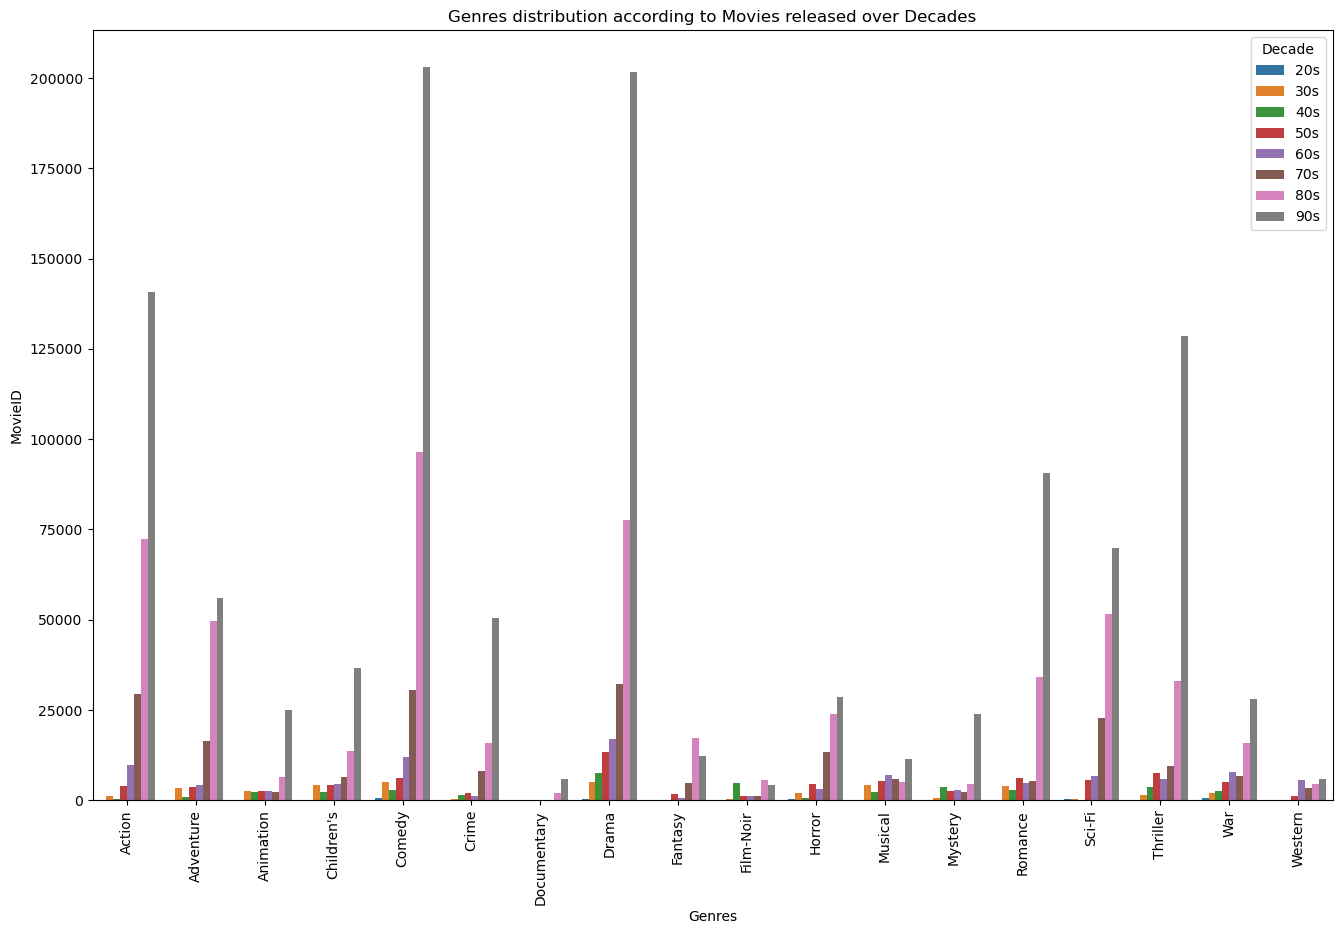

In [265]:
# Plot the genre and movies release relationship
plt.figure(figsize=(16,10))
sns.barplot(avg_genre_decade, x='Genres', y='MovieID', hue='Decade')
plt.xticks(rotation=90)
plt.title("Genres distribution according to Movies released over Decades")
plt.show()

    - Most Comedy, Drama, Action, Thriller, Sci-Fi movies were released in the 90s
    - More Fantasy and Film Noir movies were released during the 80s

In [275]:
# Users of Age group and the movies watched and Rated
df.columns

Index(['MovieID', 'Title', 'Genres', 'Release_year', 'Decade', 'UserID',
       'Rating', 'Timestamp', 'Gender', 'Age', 'Occupation', 'Zip-code'],
      dtype='object')

In [279]:
df.groupby(['Title', 'Age']).agg({'Rating':'count', 'MovieID':"count"}).reset_index().sort_values(by='Rating', ascending=False)

,Title,Age,Rating,MovieID
18903,Star Wars: Episode V - The Empire Strikes Back,25,5880,5880
18910,Star Wars: Episode VI - Return of the Jedi,25,5670,5670
18896,Star Wars: Episode IV - A New Hope,25,4512,4512
15927,"Princess Bride, The",25,3920,3920
12794,Men in Black,25,3884,3884
...,...,...,...,...
2697,Bloodsport,1,1,1
9265,Hideous Kinky,1,1,1
9264,Hideaway,56,1,1
5495,"Designated Mourner, The",45,1,1


    - 25-34 Age group has watched maximum movies and have rated the most number of movies

In [281]:
df.groupby(['Title', 'Occupation']).agg({'Rating':'count', 'MovieID':"count"}).reset_index().sort_values(by='Rating', ascending=False)

,Title,Occupation,Rating,MovieID
49951,Star Wars: Episode VI - Return of the Jedi,College/Grad Student,2105,2105
49930,Star Wars: Episode V - The Empire Strikes Back,College/Grad Student,2055,2055
49933,Star Wars: Episode V - The Empire Strikes Back,Executive/Managerial,1695,1695
49954,Star Wars: Episode VI - Return of the Jedi,Executive/Managerial,1665,1665
49938,Star Wars: Episode V - The Empire Strikes Back,Other or not specified,1660,1660
...,...,...,...,...
21593,God Said 'Ha!',Programmer,1,1
3717,At First Sight,Tradesman/Craftsman,1,1
21594,God Said 'Ha!',Scientist,1,1
10129,"Champ, The",Clerical/Admin,1,1


    - Most of the College/Grad Students have watched and rated most movies

In [282]:
df.groupby(['Title', 'Gender']).agg({'Rating':'count'}).reset_index().sort_values(by='Rating', ascending=False)

,Title,Gender,Rating
6025,Star Wars: Episode V - The Empire Strikes Back,M,11710
6027,Star Wars: Episode VI - Return of the Jedi,M,11150
6023,Star Wars: Episode IV - A New Hope,M,9376
4086,Men in Black,M,8000
6021,Star Wars: Episode I - The Phantom Menace,M,7136
...,...,...,...
4344,Mutters Courage,M,1
6437,Tinseltown,M,1
5892,Song of Freedom,F,1
5895,Sonic Outlaws,F,1


    - Most of the Male users have rated the movies in our Dataset

#### Insights:
- Ratings of the movies usually lie between 3-4. Hence, the recommendations will always be average
- There is minimum participation of people from the Age group Under18, 56+ and 45 above, this can create bias
- Users in Age group 45+ tend to rate higher as compared to their younger counterparts
- The data is huge, hence we might face memory constraints

### Data Pre-processing

In [283]:
# Keep the unique datapoints only
df = df.drop_duplicates(subset=['MovieID',"Title","UserID",'Timestamp','Release_year']).reset_index(drop = True)

In [284]:
print(f"Final merged Dataframe = {df.shape}")

Final merged Dataframe = (1000209, 12)


In [285]:
df.info()
# No missing values in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   MovieID       1000209 non-null  int64         
 1   Title         1000209 non-null  object        
 2   Genres        1000209 non-null  object        
 3   Release_year  1000209 non-null  int64         
 4   Decade        1000209 non-null  object        
 5   UserID        1000209 non-null  int64         
 6   Rating        1000209 non-null  int64         
 7   Timestamp     1000209 non-null  datetime64[ns]
 8   Gender        1000209 non-null  object        
 9   Age           1000209 non-null  int64         
 10  Occupation    1000209 non-null  object        
 11  Zip-code      1000209 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 91.6+ MB


In [296]:
# Find the movie with maximum number of Ratings
df.groupby(['Title', 'MovieID']).agg({'Rating':'count'}).reset_index().sort_values('Rating', ascending=False)

,Title,MovieID,Rating
127,American Beauty,2858,3428
3153,Star Wars: Episode IV - A New Hope,260,2991
3154,Star Wars: Episode V - The Empire Strikes Back,1196,2990
3155,Star Wars: Episode VI - Return of the Jedi,1210,2883
1789,Jurassic Park,480,2672
...,...,...,...
3274,Target,139,1
1625,I Don't Want to Talk About It (De eso no se ha...,584,1
156,An Unforgettable Summer,790,1
2343,Never Met Picasso,1714,1


    - American Beauty is the movie with maximum ratings

### Group the Dataframe according to the average Rating of the movies and their number of ratings

In [310]:
title_details = df.groupby(['MovieID', 'Title']).agg({'Rating':['mean', 'count']}).reset_index()

In [317]:
title_details.columns = ['MovieID', 'Title', 'Rating Avg', 'Rating Count']

In [319]:
title_details['Rating Avg'] = title_details['Rating Avg'].round(2)

In [320]:
title_details

,MovieID,Title,Rating Avg,Rating Count
0,1,Toy Story,4.15,2077
1,2,Jumanji,3.20,701
2,3,Grumpier Old Men,3.02,478
3,4,Waiting to Exhale,2.73,170
4,5,Father of the Bride Part II,3.01,296
...,...,...,...,...
3701,3948,Meet the Parents,3.64,862
3702,3949,Requiem for a Dream,4.12,304
3703,3950,Tigerland,3.67,54
3704,3951,Two Family House,3.90,40


## Pivot Table UserID vs Movie Title

In [321]:
# Copy the merged final dataframe into new
df_copy = df.copy()

In [322]:
df_copy.sample(10)

,MovieID,Title,Genres,Release_year,Decade,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
549457,2702,Summer of Sam,Drama,1999,90s,5738,2,2000-05-15 19:27:26,M,25,Programmer,55406
149365,329,Star Trek: Generations,Action,1994,90s,1545,2,2000-11-20 18:42:49,M,25,Writer,20009
339635,1275,Highlander,Action,1986,80s,3589,4,2000-08-19 03:13:42,F,45,Other or not specified,80010
583922,441,Dazed and Confused,Comedy,1993,90s,1168,3,2000-11-22 22:49:43,F,25,Other or not specified,94109
131911,273,Mary Shelley's Frankenstein,Drama,1994,90s,1354,3,2000-12-31 21:46:05,F,25,Artist,94040
549157,880,"Island of Dr. Moreau, The",Sci-Fi,1996,90s,5738,3,2000-05-15 19:18:27,M,25,Programmer,55406
864071,3755,"Perfect Storm, The",Action,2000,90s,218,3,2000-12-15 00:59:25,M,35,Sales/Marketing,95822
534404,911,Charade,Comedy,1963,60s,5605,5,2000-05-25 23:28:46,F,18,Artist,95008
861539,1291,Indiana Jones and the Last Crusade,Action,1989,80s,6018,3,2000-04-26 15:39:00,M,35,Academic/Educator,48906
772961,527,Schindler's List,Drama,1993,90s,4901,4,2000-07-04 04:34:59,M,25,Executive/Managerial,11228


In [323]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   MovieID       1000209 non-null  int64         
 1   Title         1000209 non-null  object        
 2   Genres        1000209 non-null  object        
 3   Release_year  1000209 non-null  int64         
 4   Decade        1000209 non-null  object        
 5   UserID        1000209 non-null  int64         
 6   Rating        1000209 non-null  int64         
 7   Timestamp     1000209 non-null  datetime64[ns]
 8   Gender        1000209 non-null  object        
 9   Age           1000209 non-null  int64         
 10  Occupation    1000209 non-null  object        
 11  Zip-code      1000209 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 91.6+ MB


In [344]:
# Create a pivot table of UserID as index, titles as columns, and values as ratings
pivot_table = pd.pivot_table(df_copy, values='Rating', index='UserID', columns='Title', fill_value=0)
# Display the pivot tab
pivot_table.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
# Calculate the Sparsity
print(f"Sparsity = {round((pivot_table.sum().sum())/pivot_table.size*100,2)}%")

Sparsity = 16.14%


In [359]:
print(f"Pivot table shape = {pivot_table.shape}")

Pivot table shape = (6040, 3664)


### Pearson Correlation Approach for item-based approach

In [360]:
# Find the movies similar to 'Liar Liar'
movie_input = input("Enter the movie name")
movie_rating = pivot_table[movie_input]

# Store the related movies correlation matrix with that of the movie_inp
related_movies = pivot_table.corrwith(movie_rating)

Enter the movie name Liar Liar


In [363]:
# Sort the related values
related_movies.sort_values(ascending=False).iloc[1:].head()

Title
Mrs. Doubtfire                0.499927
Dumb & Dumber                 0.459601
Ace Ventura: Pet Detective    0.458654
Home Alone                    0.455967
Wedding Singer, The           0.429222
dtype: float64

    - The similar ovies to the 'Liar Liar' are 
    * Mrs. Doubtfire
    * Dumb & Dumber                
    * Ace Ventura: Pet Detective  

### Cosine similarity for item-item and user-user similarities

### Item-item similarity

In [368]:
# Create a pivot table of movies and user ratings
pivot_table_cos = pd.pivot_table(df_copy, values='Rating', index='UserID', columns='Title', fill_value=0)
# Calculate cosine similarity for item-item similarity based on movie titles
item_similarity = cosine_similarity(pivot_table_cos.T)

In [376]:
# Create a dataframe of item-item similarity
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table_cos.columns, columns = pivot_table_cos.columns)
# Display the item-item similarity dataframe
item_similarity_df.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


### User-User Similarity

In [377]:
# Calculate cosine similarity for user-user similarity based on user ratings
user_similarity = cosine_similarity(pivot_table_cos)
# Create a dataframe of user-user similarity
user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table_cos.index, columns = pivot_table_cos.index)
# Display the user-user similarity dataframe
user_similarity_df.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254736,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.186957,0.136233,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227745,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.229011,0.206660,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214487,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143747,0.107945,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.121208,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.171158,0.127703,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117508,...,0.100652,0.035732,0.065278,0.054151,0.179083,0.294354,0.173009,0.020459,0.027689,0.241437


## Employ the Nearest Neighbors algorithm with Cosine Similarity to find and recommend similar movies.

In [378]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
# Create a sparse matrix using the CSR format
sparse_matrix = csr_matrix(pivot_table_cos.T.values)
# Fit the Nearest Neighbors model using Cosine Similarity
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_matrix)
# Get input movie name from the user
movie_name = input("Enter the name of a movie: ")
# Find the index of the input movie in the pivot table
movie_index = pivot_table_cos.columns.get_loc(movie_name)
# Find the 6 nearest neighbors (including the input movie itself)
distances, indices = model.kneighbors(sparse_matrix[movie_index], n_neighbors=6)
# Get the indices of the recommended movies (excluding the input movie itself)
recommended_indices = indices.flatten()[1:]
# Get the titles of the recommended movies
recommended_movies = pivot_table_cos.columns[recommended_indices]
# Display the top 5 recommended movies
print("Top 5 recommended movies similar to", movie_name)
for i, movie in enumerate(recommended_movies[:5], 1):
    print(i, "-", movie)

Enter the name of a movie:  Liar Liar


Top 5 recommended movies similar to Liar Liar
1 - Mrs. Doubtfire
2 - Ace Ventura: Pet Detective
3 - Dumb & Dumber
4 - Home Alone
5 - Wayne's World


## Matrix Factorization for recommendation

In [379]:
# install cmfrec library
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 2.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-3.0.9-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached findblas-0.1.23-py3-none-any.whl
Using cached Cython-3.0.9-py2.py3-none-any.whl (1.2 MB)
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post8-cp312-cp312-macosx_11_0_arm64.whl size=1061394 sha256=49710db53e8749c3de86c652cd181f33284fcd0306cdd63a703c015a11c74e6d
  Stored in directory: /Users/moon/Library/Caches/pip/wheels/02/10/dc/207bf10c828257f8520b13c7a3ac797b8e0173c61f7e15344e
Successfully built cmfrec


In [381]:
from sklearn.model_selection import train_test_split
from cmfrec import CMF
# Step 2: Load and preprocess the data
# Assuming you have a DataFrame named df_copy with columns UserID, MovieID, Rating
data = df_copy[['UserID', 'MovieID', 'Rating']]

# Step 3: Rename columns to match the expected format by CMF model
data.rename(columns={'UserID': 'UserId', 'MovieID': 'ItemId'}, inplace=True)

# Step 4: Split the data into training and testing sets for Matrix Factorization
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21)

# Step 5: Train the Matrix Factorization model with d=4 embeddings
model = CMF(k=4, random_state=21, niter=100)
model.fit(train_data)

/var/folders/vm/pdpb8c_x2kz5jqk_zhcvs8kr0000gn/T/ipykernel_72166/4102517052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'UserID': 'UserId', 'MovieID': 'ItemId'}, inplace=True)
/Users/moon/miniforge3/envs/env_scaler/lib/python3.12/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


In [425]:
# Step 6: Evaluate the model's performance using RMSE and MAPE
predictions = []
for _, row in test_data.iterrows():
    user_id, item_id = row['UserId'], row['ItemId']
    pred_rating = model.predict(user=user_id, item=item_id)
    pred_rating = round(pred_rating.item(),2)
    predictions.append(pred_rating)
   
predictions = np.array(predictions)
rmse = np.sqrt(np.mean((test_data['Rating'] - predictions)**2))
mape = np.mean(np.abs(test_data['Rating'] - predictions) / test_data['Rating']) * 100
print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 0.8630677215390966
MAPE: 26.33849991501784


In [429]:
# Step 7: Use the learned embeddings for visualization and similarity-based models
user_embeddings = model.A_
item_embeddings = model.B_

# Step 8: Redesign item-item and user-user similarity functions using MF embeddings
# For example, to compute cosine similarity between item embeddings
def item_item_similarity(item_id_1, item_id_2):
    emb_1 = item_embeddings[item_id_1]
    emb_2 = item_embeddings[item_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Similarly, compute user-user similarity using MF embeddings
def user_user_similarity(user_id_1, user_id_2):
    emb_1 = user_embeddings[user_id_1]
    emb_2 = user_embeddings[user_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity


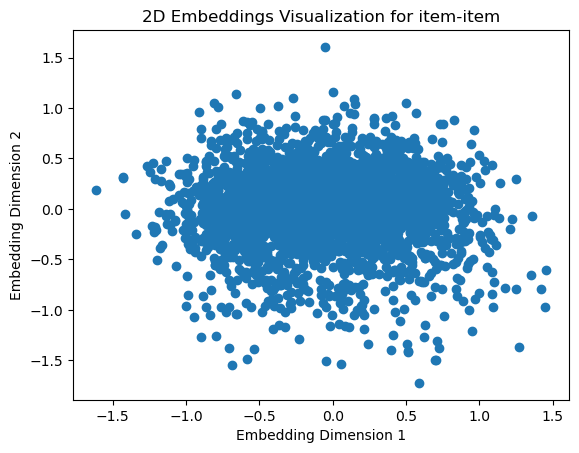

In [430]:
# Bonus: Get d=2 embeddings and plot the results
model_2d = CMF(k=2, random_state=42, niter=100)
model_2d.fit(train_data)
item_embeddings_2d = model_2d.B_
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('2D Embeddings Visualization for item-item')
plt.show()

### Surprise Library

In [431]:
# Step 1: Install Surprise library
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp312-cp312-macosx_11_0_arm64.whl size=1288863 sha256=109dd279dcd0ee771b68db98561a3ad2b42d3a37916564dae9e25189ad5deebc
  Stored in directory: /Users/moon/Library/Caches/pip/wheels/ee/08/67/4176eedbed1c63c15db21a526f1893ca43ee8453182a239afc
Successfully built scikit-surprise


### Evaluate the model in terms of the Root Mean Squared Error and Mean Absolute Percentage Error

In [433]:
# Step 2: Import necessary modules from Surprise
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
# Step 3: Load your dataset into Surprise
# Assuming you have a DataFrame named final_df_copy with columns UserID, MovieID, a
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_copy[['UserID', 'MovieID', 'Rating']], reader)
# Step 4: Split the data into training and testing sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
# Step 5: Train the Matrix Factorization model (SVD) on the training set
model = SVD(n_factors=4, random_state=42)
model.fit(train_set)
# Step 6: Make predictions on the test set
predictions = model.test(test_set)
# Step 7: Evaluate the model's performance using RMSE
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)

RMSE: 0.8827
RMSE: 0.8826968163330328


In [434]:
# Step 12: Make predictions using the trained SVD model
predictions = [model.predict(uid, iid, r_ui_trans) for (uid, iid, r_ui_trans) in test_set]
# Step 13: Compute absolute percentage error for each prediction
absolute_percentage_errors = []
for prediction in predictions:
    actual_rating = prediction.r_ui
    predicted_rating = prediction.est
    absolute_percentage_error = abs((actual_rating - predicted_rating) / actual_rating)
    absolute_percentage_errors.append(absolute_percentage_error)
# Step 14: Calculate MAPE
mape = np.mean(absolute_percentage_errors)
print("MAPE:", mape)

MAPE: 0.27015411104452264


### Use embeddings for visualization and similarity based models.

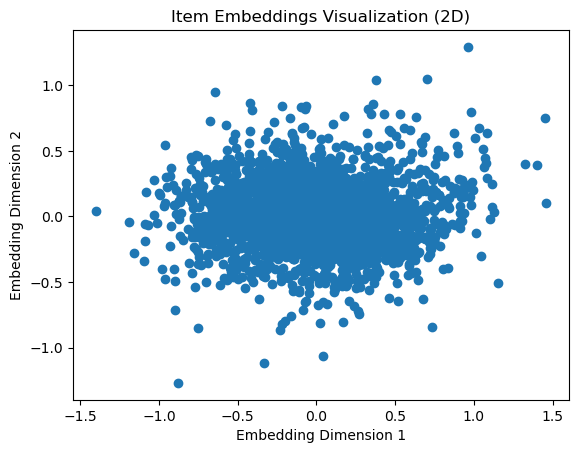

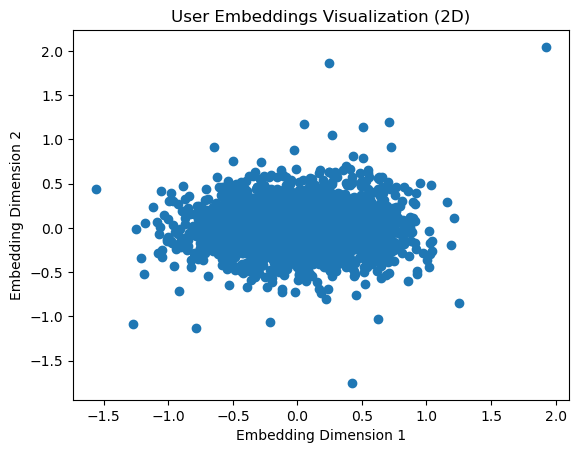

In [435]:
from sklearn.decomposition import PCA

# Step 8: Extract item and user embeddings from the trained SVD model
item_embeddings = model.qi
user_embeddings = model.pu

# Step 9: Redesign item-item similarity function using MF embeddings
def item_item_similarity(item_id_1, item_id_2):
    emb_1 = item_embeddings[item_id_1]
    emb_2 = item_embeddings[item_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Step 10: Redesign user-user similarity function using MF embeddings
def user_user_similarity(user_id_1, user_id_2):
    emb_1 = user_embeddings[user_id_1]
    emb_2 = user_embeddings[user_id_2]
    similarity = np.dot(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))
    return similarity

# Step 11: Get d=2 embeddings and plot the results
pca = PCA(n_components=2)
item_embeddings_2d = pca.fit_transform(item_embeddings)
user_embeddings_2d = pca.fit_transform(user_embeddings)
                  
# Plot item embeddings in 2D
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Item Embeddings Visualization (2D)')
plt.show()

# Plot user embeddings in 2D
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1])
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('User Embeddings Visualization (2D)')
plt.show()

In [436]:
# There are few User outliers and lesser movie outliers